In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nd_emulator import build_emulator
from data_loading_functions import load_SFHo_EOS

In [31]:
EOS_file = "../../../tables/Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5"
vars, domain = load_SFHo_EOS(EOS_file)
spacing = ['linear', 'linear', 'linear']  # We will do the transform ahead of time.
# get subset of Abar
L = 17
abar = vars['Abar']['f'][:L, :L, :L]

relative_error_dict = {
    'Abar': True,
    'X3he': False,
    'X4li': False,
    'Xa': False,
    'Xd': False,
    'Xh': False,
    'Xn': False,
    'Xp': False,
    'Xt': False,
    'Zbar': True,
    'cs2': True,
    'dedt': True,
    'dpderho': True,
    'dpdrhoe': True,
    'entropy': True,
    'gamma': True,
    'logenergy': True,
    'logpress': True,
    'mu_e': True,
    'mu_n': True,
    'mu_p': True,
    'muhat': True,
    'munu': True
}

# Specify model types
# -- add each model type to the list in the format of a dict {'type': name, ...}
model_classes = [{'type': 'nd-linear'}]
error_type = 'RMSE'

# set tree parameters
# -- Make sure the depth of the tree is not so deep that there is not enough data
# -- for example. If the smallest values in dims is 2**3+1, then the max depth you
# -- can choose is 3.
max_depth = 100  # as much refinement as needed.
error_threshold = -1.0
max_test_points = 100  # The max number of points to eval in a cell when estimating the error
relative_error = True  # Whether or not the error threshold is absolute or relative error

# create the emulator (should not need to modify this)
emulator, tree = build_emulator({'f': abar}, max_depth, domain, spacing, error_threshold, model_classes,
                                max_test_points=max_test_points, relative_error=relative_error,
                                expand_index_domain=True, return_tree=True, error_type=error_type)

max_depth = tree.achieved_depth
leaves = tree.get_leaves()

D =max_depth
num_dims = tree.num_dims
# n = 2**(D*num_dims)
# errors = np.zeros([n, D+1])
# ids = np.zeros_like(errors)
# def get_errors(ni, nf, d, node):
#     if d == D+1:
#         return
#     errors[ni:nf, d] = node['error']
#     s_id = '0'
#     for s in node['id']:
#         s_id += f'{s}'
#     ids[ni:nf, d] = float(s_id)
#     nx = (nf - ni)//2**num_dims
#     if d < D:
#         for i in range(2**num_dims):
#             get_errors(ni + i*nx, ni + (i+1)*nx, d+1, node['children'][i])
#     return
#
# get_errors(0, n, 0, tree.root)

E = []
for leaf in leaves:
    if leaf['error'] is not None:
      E.append(leaf)
errors_1 = np.zeros([len(E),max_depth+1])
EPS = 10**-16
for i in range(len(E)):
    current_node = tree.root
    errors_1[i, 0] = current_node['error']
    for j in range(max_depth):
        current_node = current_node['children'][E[i]['id'][j]]
        errors_1[i, j+1] = current_node['error']
    h = 1
    # linear fit
    hs = np.log(np.array([1, 0.5, 0.25, 0.125, 0.125/2.]))
    fit = np.polyfit(hs[-3:-1], np.log(errors_1[i, -3:-1] + EPS), h)
    last_col = fit[0]*hs[-1] + fit[1]
    errors_1[i,-1] = np.exp(last_col)



C:\Users\carls502\OneDrive - Michigan State University\Research\ANL\ND-tree_tabular_data_emulator\nd_emulator\domain_functions.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if spacings[i] == 'linear':
C:\Users\carls502\OneDrive - Michigan State University\Research\ANL\ND-tree_tabular_data_emulator\nd_emulator\domain_functions.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif spacings[i] == 'log':


WARNING!
You have chosen a max depth that is greater than can be supported by your data.
The max depth has been changed to 4.



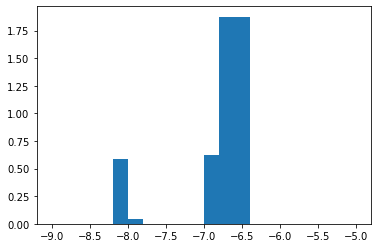

In [32]:

data = np.array([max(10**-16, v) for v in errors_1[:,-1]])
bins = 20
d, b, p = plt.hist(np.log10(data), bins, density=True, range=[-9, -5])
# plt.plot(d,b)

In [17]:

errors_loaded = np.load('./errors_Abar.npy')

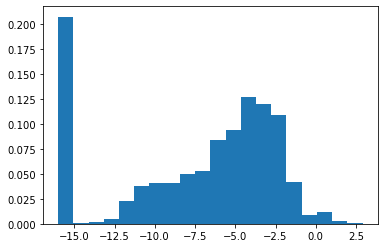

In [7]:


data = np.array([max(10**-16, v) for v in errors_loaded[:,-1]])
bins = 20
d, b, p = plt.hist(np.log10(data), bins, density=True)
# plt.plot(d,b)

In [9]:

EOS_file = "../../../tables/Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5"
vars, domain = load_SFHo_EOS(EOS_file)

In [18]:
for key in vars.keys():
    max = np.max(vars[key]['f'])
    min = np.min(vars[key]['f'])
    print(f'{key: <10}: max= {max:9.2e}, min = {min:9.2e}')

Abar      : max=  3.39e+02, min =  1.00e+00
X3he      : max=  1.16e-01, min =  0.00e+00
X4li      : max=  2.16e-02, min =  0.00e+00
Xa        : max=  9.78e-01, min =  0.00e+00
Xd        : max=  1.94e-01, min =  0.00e+00
Xh        : max=  1.00e+00, min =  0.00e+00
Xn        : max=  9.90e-01, min = 2.57e-104
Xp        : max=  6.00e-01, min = 1.43e-133
Xt        : max=  1.67e-01, min =  0.00e+00
Zbar      : max=  1.35e+02, min =  1.00e+00
cs2       : max=  5.13e+32, min = -4.71e+18
dedt      : max=  3.62e+31, min = -1.41e+18
dpderho   : max=  1.68e+19, min = -4.89e+17
dpdrhoe   : max=  3.85e+32, min = -6.47e+24
entropy   : max=  1.25e+13, min =  1.61e-04
gamma     : max=  3.00e+03, min = -2.50e+01
logenergy : max=  3.32e+01, min =  1.61e+01
logpress  : max=  3.67e+01, min =  1.80e+01
mu_e      : max=  6.38e+02, min =  9.36e-07
mu_n      : max=  2.36e+03, min = -2.73e+03
mu_p      : max=  2.25e+03, min = -2.73e+03
muhat     : max=  6.74e+02, min = -9.43e+01
munu      : max=  7.16e+02, min 